In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#https://drive.google.com/file/d/1Dr7S2YlcEAxH9JGj5gGQRuDvN7qfRBZV/view?usp=sharing
#https://drive.google.com/file/d/1KX2pgfmBHyX3M7MXRqhskVkX0MkokdbU/view?usp=sharing
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1Dr7S2YlcEAxH9JGj5gGQRuDvN7qfRBZV'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

file_id = '1KX2pgfmBHyX3M7MXRqhskVkX0MkokdbU'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
data = np.load('faces.npy')

In [ ]:
target = np.load('faces_target.npy')

In [ ]:
X_train_s = data.reshape(-1,64*64)

In [ ]:
X_train_s.shape,target.shape,data.shape

((400, 4096), (400,), (400, 64, 64))

In [ ]:
X_train_s = X_train_s - np.mean(X_train_s,axis=0)

In [ ]:
np.mean(X_train_s,axis=0)

array([-5.9232114e-08,  8.8512898e-08,  1.0833144e-07, ...,
       -6.1392782e-08, -2.2321939e-07, -9.1791151e-08], dtype=float32)

In [ ]:
pd.DataFrame(X_train_s)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.090217,-0.066467,-0.058926,-0.076333,-0.025919,0.018709,0.035599,0.030175,0.025269,0.009360,0.016271,0.005775,-0.005186,-0.006529,-0.020072,-0.019669,-0.028151,-0.023998,-0.022666,-0.025134,-0.031353,-0.023451,-0.020217,-0.010899,-0.002449,0.025909,0.044317,0.050062,0.051509,0.032087,0.036085,0.055248,0.033978,0.042345,0.029298,0.013853,0.018244,0.015031,0.021684,0.000248,...,0.253564,0.245011,0.186746,0.182655,0.176591,0.180124,0.159845,0.154917,0.146074,0.142056,0.147696,0.135434,0.130579,0.156333,0.194618,0.202252,0.199318,0.210454,0.209835,0.211085,0.189690,0.148192,0.120052,0.127779,0.133523,0.154669,0.178430,0.226209,0.256725,0.290351,0.302211,0.302200,0.289866,0.305651,0.135010,-0.206426,-0.187149,-0.168523,-0.152490,-0.153430
1,0.054411,0.036839,0.036116,0.039370,0.040196,0.051767,0.060392,0.054969,0.045930,0.025889,0.024535,0.005775,0.003079,0.001735,-0.003543,0.000992,-0.003357,-0.015734,-0.026798,-0.012738,-0.031353,-0.006922,0.000444,0.013895,0.026477,0.042438,0.040185,0.058326,0.039112,0.032087,0.007159,0.018058,0.009184,-0.007242,-0.020289,-0.010940,-0.006549,-0.013894,-0.011374,-0.012149,...,0.170919,0.154101,0.145424,0.120671,0.127004,0.142934,0.143316,0.134256,0.141942,0.146188,0.139432,0.131302,0.130579,0.115010,0.103709,0.078285,0.038161,0.061694,0.114793,0.116044,0.119442,0.123399,0.124184,-0.297841,-0.308626,-0.246157,-0.238926,-0.257262,-0.239142,-0.234442,-0.226715,-0.210196,-0.226663,-0.206746,-0.187304,-0.185764,-0.183017,-0.168523,-0.160754,-0.157562
2,-0.081953,-0.033409,0.015455,0.010444,0.031932,0.068296,0.060392,0.038440,0.037665,0.021756,0.016271,0.014039,0.007211,0.010000,0.000589,-0.007272,-0.011622,-0.015734,-0.002004,-0.008605,-0.010692,-0.019318,-0.020217,0.022159,0.026477,0.034174,0.056714,0.070723,0.113492,0.102335,0.118729,0.121364,0.104226,0.091932,0.066488,0.042779,0.034773,0.031560,0.017552,-0.008017,...,0.216374,0.207820,0.199143,0.178523,0.160062,0.151198,0.147448,0.142521,0.133678,0.146188,0.168358,0.156095,0.188430,0.193523,0.202882,0.206384,0.211715,0.210454,0.197438,0.198688,0.193822,0.152324,0.124184,0.160837,0.203771,0.204256,0.203223,0.193151,0.231932,0.046550,-0.288698,-0.234990,-0.181209,-0.219143,-0.212097,-0.189897,-0.191281,-0.180919,-0.164887,-0.157562
3,-0.201787,-0.240021,-0.282066,-0.324267,-0.364762,-0.398646,-0.377624,-0.242552,-0.181343,-0.160062,-0.149018,-0.126457,-0.125021,-0.118100,-0.098585,-0.081653,-0.077738,-0.065320,-0.051591,-0.033399,-0.027221,-0.011054,-0.003688,-0.010899,-0.006581,-0.019545,0.011260,0.021136,0.030847,0.032087,0.040217,0.046984,0.058771,0.058874,0.078884,0.092366,0.080228,0.085279,0.071271,0.070496,...,-0.101808,-0.064907,-0.028130,0.004969,0.031963,0.056157,0.068936,0.092934,0.096488,0.125527,0.143564,0.172624,0.192562,0.185258,0.227676,0.227045,0.228244,0.218719,0.218099,0.169763,0.173161,0.152324,0.161374,0.169101,0.187242,0.191859,0.219752,0.242738,0.269122,0.290351,0.289814,0.269143,0.293998,0.330444,0.387076,0.405145,0.428554,0.430651,0.438419,0.429215
4,0.099866,0.111219,0.106364,0.105485,0.093915,0.101354,0.072789,0.067366,0.058327,0.054814,0.053461,0.047097,0.065062,0.051322,0.054308,0.071240,0.075155,0.075176,0.088905,0.082304,0.080217,0.088120,0.099618,0.100672,0.113254,0.108554,0.110433,0.112045,0.105228,0.094070,0.081539,0.075909,0.071168,0.067139,0.066488,0.059308,0.071963,0.077015,0.071271,0.074628,...,0.059349,0.050796,0.066911,0.087614,0.093947,0.109876,0.126787,0.142521,0.179132,0.191642,0.209680,0.209814,0.225620,0.222448,0.277262,0.272500,0.306756,0.326157,0.275950,0.260672,0.239277,0.185382,-0.127882,-0.264783,-0.250775,-0.246157,-0.234793,-0.236601,-0.214349,-0.205517,-0.172996,-0.206064,-0.185341,-0.

# PCA explained variance

In [ ]:
def plot_explained_var(n_components,train):
    pca = PCA(n_components=n_components)
    pca.fit(train)
    pca_var_cumsum = (pca.explained_variance_ratio_).cumsum()
    plt.figure(figsize=(10,7))
    plt.plot(pca_var_cumsum)
    plt.grid()
    plt.xlabel('n_components')
    plt.ylabel('Cumulative_explained_variance')
    plt.title('Cumulative Explained variance vs no of PCA components')
    return pca_var_cumsum

def get_index(pca_var_cumsum,ratio):
    index=0
    for value in pca_var_cumsum:
        if value>=ratio:
            return index
        index+=1

principal components required to preserve 99% variance 259
principal components required to preserve 95% variance 122
principal components required to preserve 90% variance 65
principal components required to preserve 80% variance 26
principal components required to preserve 75% variance 18


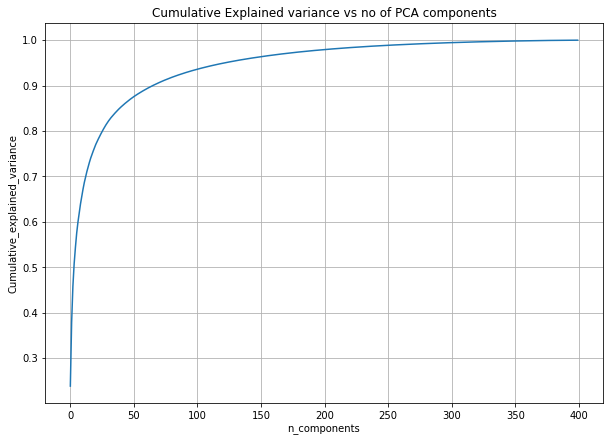

In [ ]:
pca_var_cumsum = plot_explained_var(400,X_train_s)

print("principal components required to preserve 99% variance",get_index(pca_var_cumsum,0.99))
print("principal components required to preserve 95% variance",get_index(pca_var_cumsum,0.95))
print("principal components required to preserve 90% variance",get_index(pca_var_cumsum,0.90))
print("principal components required to preserve 80% variance",get_index(pca_var_cumsum,0.80))
print("principal components required to preserve 75% variance",get_index(pca_var_cumsum,0.75))

In [ ]:
def get_pca(n_components,ttrain):
    pca = PCA(n_components=n_components)
    pca.fit(ttrain)
    return pca

def reconstruct_image(pca,image):
    decoded = (pca.inverse_transform(image)).reshape(64,64)
    return decoded

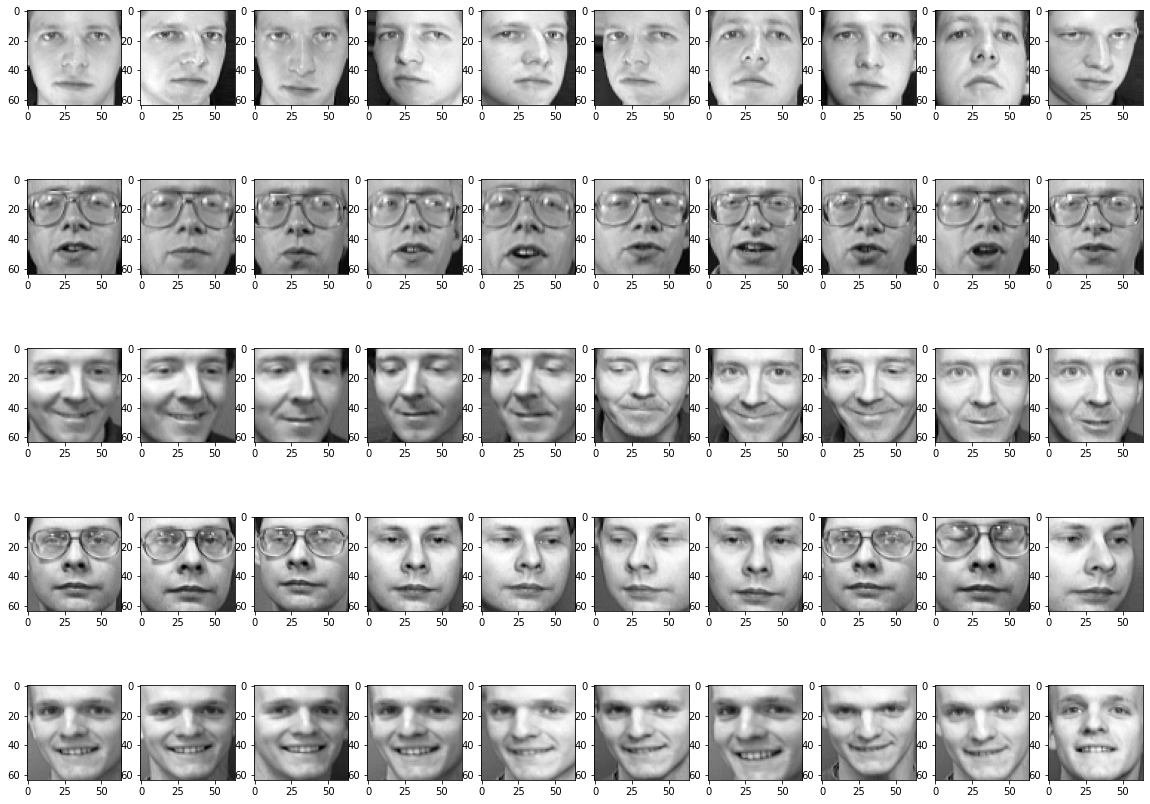

In [ ]:
fig = plt.figure(figsize=(20,15))
axes=[]
rows = 5
cols = 10
p=0
for i in range(5):
  for j in range(10):
    #print(i*10+j)
    
    axes.append( fig.add_subplot(rows, cols, p+1) )
    plt.imshow(data[i*10+j],'gray')
    p+=1
    
plt.show()

# classification

In [ ]:
def classify(X_train_s,target,n_components):
  sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
  accs = []
  for train_index, test_index in sss.split(X_train_s, target):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_train_s[train_index], X_train_s[test_index]
        y_train, y_test = target[train_index], target[test_index]
        pca = get_pca(n_components=n_components,ttrain=X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        #print(np.bincount(y_test))
        models=[]
        models.append(("LR",LogisticRegression()))
        models.append(("KNN",KNeighborsClassifier(n_neighbors=3)))
        #models.append(("DT",DecisionTreeClassifier()))
        #models.append(("SVM",SVC()))
        models.append(("rnf",RandomForestClassifier()))

        tmp_acc = []
        for name, model in models:
            clf=model
            clf.fit(X_train_pca, y_train)
            
            y_pred=clf.predict(X_test_pca)
            
            #print(10*"=","{} Result".format(name).upper(),10*"=")
            tmp_acc.append(metrics.accuracy_score(y_test, y_pred))
            #print("Accuracy score:{:0.2f}".format(tmp_acc[-1]))
            #print()
        accs.append(tmp_acc)
  accs=np.asarray(accs)
  print("Mean of accuracy: ",np.mean(accs,axis=0))
  return np.mean(accs,axis=0)

In [ ]:
acc = []
n_comps = [0.10,0.30,0.50,0.60,0.75,0.80,0.85,0.90,0.95,0.99]
for n_comp in n_comps:
  acc.append(classify(X_train_s,target,n_comp))

Mean of accuracy:  [0.11666667 0.12916667 0.13333333]
Mean of accuracy:  [0.175      0.25833333 0.27083333]
Mean of accuracy:  [0.44583333 0.52916667 0.59166667]
Mean of accuracy:  [0.75416667 0.79583333 0.76666667]
Mean of accuracy:  [0.95416667 0.84583333 0.9125    ]
Mean of accuracy:  [0.9625     0.8625     0.90833333]
Mean of accuracy:  [0.96666667 0.89166667 0.9125    ]
Mean of accuracy:  [0.97083333 0.89166667 0.93333333]
Mean of accuracy:  [0.96666667 0.89583333 0.92083333]
Mean of accuracy:  [0.975  0.8875 0.925 ]


In [ ]:
acc = np.asarray(acc)

Text(0.5, 1.0, 'Accuracy vs PCA explained variance for Logistic Regression')

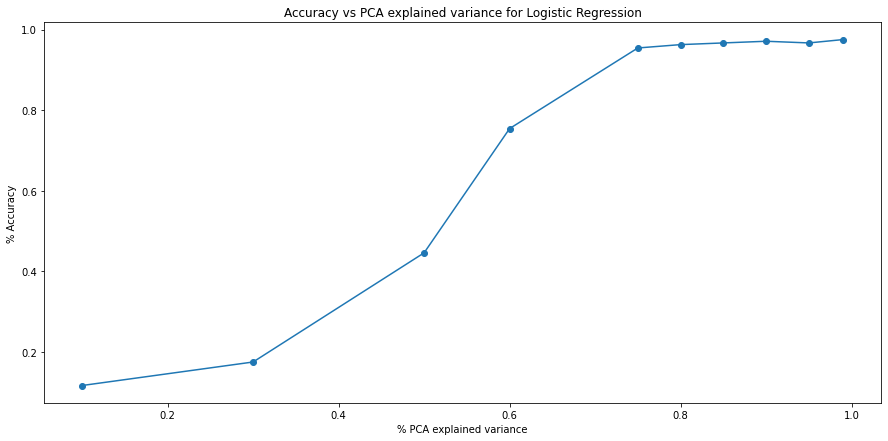

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(n_comps,acc[:,0],marker='o')
plt.xlabel('% PCA explained variance')
plt.ylabel('% Accuracy')
plt.title('Accuracy vs PCA explained variance for Logistic Regression')

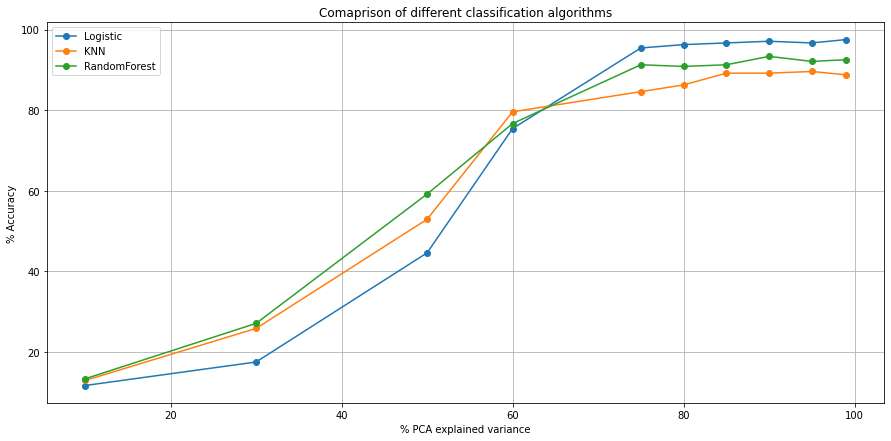

In [ ]:
lbl =  ['Logistic','KNN','RandomForest']
plt.figure(figsize=(15,7))
for i in range(len(lbl)):
  plt.plot(np.array(n_comps)*100,acc[:,i]*100,marker='o',label=lbl[i])

#plt.ylim([0,1])
plt.legend()
plt.xlabel('% PCA explained variance')
plt.ylabel('% Accuracy')
plt.title('Comaprison of different classification algorithms')
plt.grid()
plt.show()

In [ ]:
def knn_classify(X_train_s,target,n_components,ngb):
  sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
  accs = []
  for train_index, test_index in sss.split(X_train_s, target):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_train_s[train_index], X_train_s[test_index]
        y_train, y_test = target[train_index], target[test_index]
        pca = get_pca(n_components=n_components,ttrain=X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        #print(np.bincount(y_test))
        models=[]
        models.append(("KNN",KNeighborsClassifier(n_neighbors=ngb)))
        
        tmp_acc = []
        for name, model in models:
            clf=model
            clf.fit(X_train_pca, y_train)
            
            y_pred=clf.predict(X_test_pca)
            
            #print(10*"=","{} Result".format(name).upper(),10*"=")
            tmp_acc.append(metrics.accuracy_score(y_test, y_pred))
            #print("Accuracy score:{:0.2f}".format(tmp_acc[-1]))
            #print()
        accs.append(tmp_acc)
  accs=np.asarray(accs)
  print("Mean of accuracy: ",np.mean(accs,axis=0))
  return np.mean(accs,axis=0)

In [ ]:
np.arange(1,100,4)

array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
       69, 73, 77, 81, 85, 89, 93, 97])

In [ ]:
acc_knn = []
ngbs = np.arange(1,100,4)#[1,3,5,7,10]
for ngb in ngbs:
  acc_knn.append(knn_classify(X_train_s,target,0.95,ngb))

Mean of accuracy:  [0.9375]
Mean of accuracy:  [0.8625]
Mean of accuracy:  [0.75]
Mean of accuracy:  [0.66666667]
Mean of accuracy:  [0.62083333]
Mean of accuracy:  [0.5875]
Mean of accuracy:  [0.5375]
Mean of accuracy:  [0.50833333]
Mean of accuracy:  [0.475]
Mean of accuracy:  [0.45833333]
Mean of accuracy:  [0.41666667]
Mean of accuracy:  [0.39583333]
Mean of accuracy:  [0.38333333]
Mean of accuracy:  [0.37916667]
Mean of accuracy:  [0.39166667]
Mean of accuracy:  [0.39166667]
Mean of accuracy:  [0.34583333]
Mean of accuracy:  [0.325]
Mean of accuracy:  [0.30416667]
Mean of accuracy:  [0.2625]
Mean of accuracy:  [0.2625]
Mean of accuracy:  [0.25833333]
Mean of accuracy:  [0.25416667]
Mean of accuracy:  [0.225]
Mean of accuracy:  [0.2125]


In [ ]:
acc_knn = np.asarray(acc_knn)

Text(0.5, 1.0, 'Accuracy vs No of Nearest Neighbours for KNN for explained variance 95%')

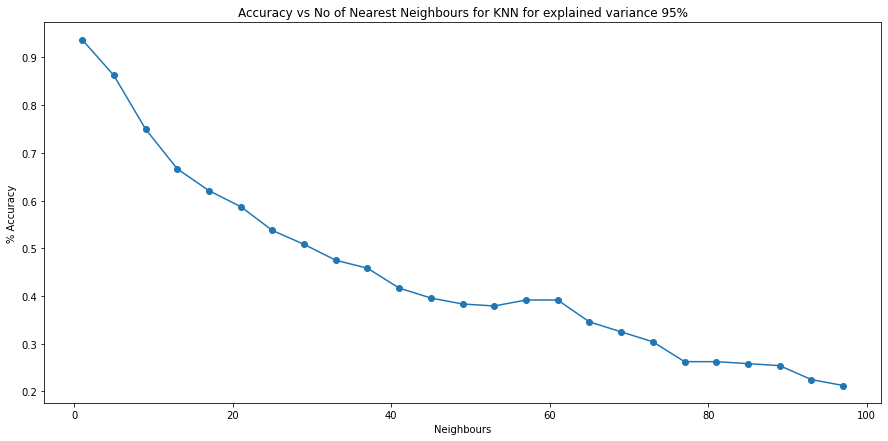

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(ngbs,acc_knn[:,0],marker='o')
plt.xlabel('Neighbours')
plt.ylabel('% Accuracy')
plt.title('Accuracy vs No of Nearest Neighbours for KNN for explained variance 95%')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def classify_normsampling(X_train_s,target,n_components):
  X_train, X_test, y_train, y_test = train_test_split(X_train_s,target, test_size=0.2, random_state=42)
  pca = get_pca(n_components=n_components,ttrain=X_train)
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  
        
  #print(np.bincount(y_test))
  models=[]
  models.append(("LR",LogisticRegression()))
  models.append(("KNN",KNeighborsClassifier(n_neighbors=3)))
  #models.append(("DT",DecisionTreeClassifier()))
  #models.append(("SVM",SVC()))
  models.append(("rnf",RandomForestClassifier()))
  
  accs = []
  for name, model in models:
      clf=model
      clf.fit(X_train_pca, y_train)
      
      y_pred=clf.predict(X_test_pca)
      
      #print(10*"=","{} Result".format(name).upper(),10*"=")
      accs.append(metrics.accuracy_score(y_test, y_pred))
      #print("Accuracy score:{:0.2f}".format(tmp_acc[-1]))
      #print()
  
  accs=np.asarray(accs)
  print("Mean of accuracy: ",accs)
  return accs

In [ ]:
acc_ns = []
n_comps = [0.10,0.30,0.50,0.60,0.75,0.80,0.85,0.90,0.95,0.99]
for n_comp in n_comps:
  acc_ns.append(classify_normsampling(X_train_s,target,n_comp))

Mean of accuracy:  [0.075 0.2   0.175]
Mean of accuracy:  [0.15   0.3375 0.325 ]
Mean of accuracy:  [0.5   0.6   0.475]
Mean of accuracy:  [0.8125 0.7375 0.775 ]
Mean of accuracy:  [0.9375 0.7875 0.9375]
Mean of accuracy:  [0.95   0.7875 0.925 ]
Mean of accuracy:  [0.95   0.8375 0.9125]
Mean of accuracy:  [0.9625 0.8375 0.925 ]
Mean of accuracy:  [0.9625 0.85   0.925 ]
Mean of accuracy:  [0.9625 0.85   0.875 ]


In [ ]:
acc_ns = np.asarray(acc_ns)

Text(0.5, 1.0, 'Accuracy vs PCA explained variance for Logistic Regression for normal and stratified sampling')

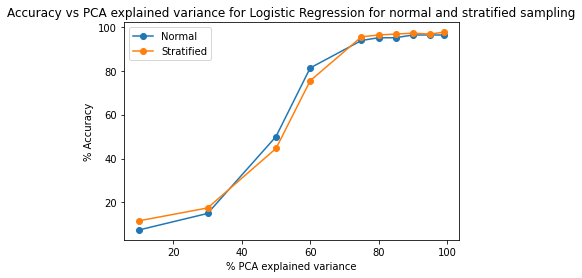

In [ ]:
plt.plot(np.array(n_comps)*100,acc_ns[:,0]*100,marker='o',label='Normal')
plt.plot(np.array(n_comps)*100,acc[:,0]*100,marker='o',label='Stratified')
plt.legend()
plt.xlabel('% PCA explained variance')
plt.ylabel('% Accuracy')
plt.title('Accuracy vs PCA explained variance for Logistic Regression for normal and stratified sampling')

Text(0.5, 1.0, 'Accuracy vs PCA explained variance for KNN classifier for normal and stratified sampling')

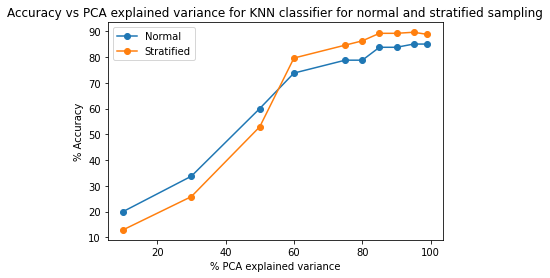

In [ ]:
plt.plot(np.array(n_comps)*100,acc_ns[:,1]*100,marker='o',label='Normal')
plt.plot(np.array(n_comps)*100,acc[:,1]*100,marker='o',label='Stratified')
plt.legend()
plt.xlabel('% PCA explained variance')
plt.ylabel('% Accuracy')
plt.title('Accuracy vs PCA explained variance for KNN classifier for normal and stratified sampling')

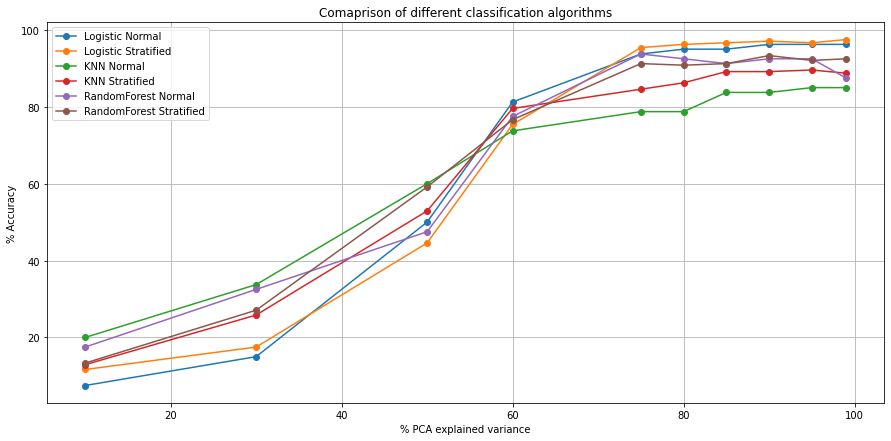

In [ ]:
lbl =  ['Logistic','KNN','RandomForest']
plt.figure(figsize=(15,7))
for i in range(len(lbl)):
  plt.plot(np.array(n_comps)*100,acc_ns[:,i]*100,marker='o',label=lbl[i]+' Normal')
  plt.plot(np.array(n_comps)*100,acc[:,i]*100,marker='o',label=lbl[i]+' Stratified')

#plt.ylim([0,1])
plt.legend()
plt.xlabel('% PCA explained variance')
plt.ylabel('% Accuracy')
plt.title('Comaprison of different classification algorithms')
plt.grid()
plt.show()